#### 1) Data Audit
- See what data is missing and observe the value counts of each column

#### 2) Exploratory analysis
- Network graph

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import sys
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
df = pd.read_csv('recipes_info.csv')

In [4]:
def data_audit(df):
    
    '''Detects missing values for each column and returns a dataframe'''
    
    # Total missing values
    mis_val = df.isnull().sum()
        
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    #unique values
    unique = pd.concat([df.apply(lambda x: x.nunique()).T], axis = 1)
        
    # Create a table
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Missing Values'})
    
    mis_val_table_ren_columns = pd.concat([mis_val_table_ren_columns, unique], axis=1)
    
    mis_val_table_ren_columns = mis_val_table_ren_columns.rename(
        columns = {0 : 'Number of unique values'})
    
    # Round values in table
    mis_val_table_ren_columns = mis_val_table_ren_columns.round(2)
        
    # Create df with missing values
    missing_values_only = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Missing Values', ascending=False)
        
    # Repeat for values with no data at all
    NO_DATA = mis_val_table_ren_columns[
    mis_val_table_ren_columns['% of Total Missing Values'] == 100]
        
    # and print the summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"   
               
            "There are " + str(missing_values_only.shape[0]) +
              " columns that have missing values.\n" + 
               
               "There are " + str(NO_DATA.shape[0]) +
              " columns that have no data.")
        
    #data audit copied to clipboard (paste into excel)
    print(mis_val_table_ren_columns.to_clipboard())
        
    # Return the dataframe
    return mis_val_table_ren_columns

In [5]:
x = data_audit(df)
x.to_clipboard()
x

Your selected dataframe has 14 columns.
There are 5 columns that have missing values.
There are 0 columns that have no data.
None


,Missing Values,% of Total Missing Values,Number of unique values
recipe_id,0,0.00,258
country,0,0.00,40
country_secondary,0,0.00,38
dish_category,8,3.08,6
dish_type,0,0.00,36
diet_type,0,0.00,4
carbohydrate_base,0,0.00,27
carbohydrate_category,30,11.54,6
protein,36,13.85,13
protein_cut,19,7.31,39


In [6]:
#create a function to concat columns. Used in pivot table agg function below
def string_concat(x):
    return  ' , '.join(x.values.astype(str))

In [7]:
def value_count(df):
    
    '''Return a Series containing counts of unique values for each column'''
    
    #create a dataframe with each column, its variable, and value count
    df = pd.concat([df.apply(lambda x: x.value_counts()).T.stack()], axis = 1)
    
    #reset index
    df = df.reset_index()
    
    #concat column variable and count
    df['Value_counts'] = df[['level_1', 0]].apply(lambda x: ' : '.join(x.astype(str)), axis=1)
    
    #create a pivot table with each colun as the index and an agg function to concat all value counts
    table = pd.pivot_table(df, index = ['level_0'], 
                       values = ['Value_counts'], 
                        aggfunc ={'Value_counts':string_concat})
    
    return table

    

In [8]:
x = value_count(df)
x.to_clipboard()
x

,Value_counts
level_0,
carbohydrate_base,"Tortillas : 5.0 , Basmati : 56.0 , white potat..."
carbohydrate_category,"Pasta : 22.0 , Rice : 78.0 , Potato : 43.0 , B..."
country,"Italy : 46.0 , India : 31.0 , China : 21.0 , U..."
country_secondary,"Italy : 41.0 , India : 29.0 , China : 21.0 , U..."
diet_type,"Meat : 144.0 , Vegetarian : 63.0 , Fish : 44.0..."
dish_category,"Stove top / bowl food : 100.0 , Protein&Veg : ..."
dish_type,"Meat & Side veg : 43.0 , Curry : 31.0 , Stir F..."
family_friendly,"No : 197.0 , Yes : 59.0 , no : 4.0"
prep_time,"30 : 71.0 , 35 : 49.0 , 20 : 41.0 , 40 : 33.0 ..."


In [9]:
def join_tables(df):
    
    '''Returns the joined above dataframes (value_counts + data_aduit)'''
    
    #create dataframes using data_audit function (see above) and value_counts function (see above)
    data_audited = data_audit(df)
    value_counts = value_count(df)
    
    #reset_index
    data_audited = data_audited.reset_index()
    value_counts = value_counts.reset_index()
    
    #rename value count table to index (for merging of dataframes)
    value_counts.rename(columns={'level_0': 'index'}, inplace=True)
    
    #inner join the two dataframes
    df = pd.merge(data_audited, value_counts, on=['index'], how='inner')
    
    #copy dataframe to clipboard (to can paste to excel or other source)
    df.to_clipboard()
    
    return df

In [10]:
join_tables(df)

Your selected dataframe has 14 columns.
There are 5 columns that have missing values.
There are 0 columns that have no data.
None


,index,Missing Values,% of Total Missing Values,Number of unique values,Value_counts
0,recipe_id,0,0.00,258,"197 : 2.0 , 348 : 2.0 , 509 : 1.0 , 868 : 1.0 ..."
1,country,0,0.00,40,"Italy : 46.0 , India : 31.0 , China : 21.0 , U..."
2,country_secondary,0,0.00,38,"Italy : 41.0 , India : 29.0 , China : 21.0 , U..."
3,dish_category,8,3.08,6,"Stove top / bowl food : 100.0 , Protein&Veg : ..."
4,dish_type,0,0.00,36,"Meat & Side veg : 43.0 , Curry : 31.0 , Stir F..."
5,diet_type,0,0.00,4,"Meat : 144.0 , Vegetarian : 63.0 , Fish : 44.0..."
6,carbohydrate_base,0,0.00,27,"Tortillas : 5.0 , Basmati : 56.0 , white potat..."
7,carbohydrate_category,30,11.54,6,"Pasta : 22.0 , Rice : 78.0 , Potato : 43.0 , B..."
8,protein,36,13.85,13,"Chicken : 59.0 , Cheese : 45.0 , Pork : 30.0 ,..."
9,protein_cut,19,7.31,39,"Eggs : 13.0 , Breast Chicken : 54.0 , Cheddar ..."


___

### Part 2) Network graph
___

In [11]:
df = df.replace(np.nan, '')

In [12]:
df['All']=df['country'].astype(str)+' '+df['dish_category']+' '+df['dish_type']+' '+df['carbohydrate_category']+' '+df['protein'] +' '+df['spice_level'] +' '+df['protein_type']

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 15 columns):
recipe_id                260 non-null int64
country                  260 non-null object
country_secondary        260 non-null object
dish_category            260 non-null object
dish_type                260 non-null object
diet_type                260 non-null object
carbohydrate_base        260 non-null object
carbohydrate_category    260 non-null object
protein                  260 non-null object
protein_cut              260 non-null object
protein_type             260 non-null object
family_friendly          260 non-null object
spice_level              260 non-null object
prep_time                260 non-null object
All                      260 non-null object
dtypes: int64(1), object(14)
memory usage: 30.5+ KB


In [14]:
df['All'] = df['All'].astype(np.str)
df['dish_type'] = df['dish_type'].astype(np.str)

In [15]:
df['All'] = df['All'].str.replace(',','')

In [16]:
df.head()

,recipe_id,country,country_secondary,dish_category,dish_type,diet_type,carbohydrate_base,carbohydrate_category,protein,protein_cut,protein_type,family_friendly,spice_level,prep_time,All
0,2,India,India,Stove top / bowl food,Curry,Fish,Basmati,Rice,Shellfish,Prawns,Fish & Seafood,No,No Spice,25,India Stove top / bowl food Curry Rice Shellfi...
1,5,Italy,Italy,Protein&Veg,Meat & Side veg,Meat,white potatoes,Potato,Beans,Butter beans,Pulses,No,Mild,35,Italy Protein&Veg Meat & Side veg Potato Beans...
2,9,Thailand,Thailand,Stove top / bowl food,Curry,Vegan,Basmati,Rice,Tofu,Protein not found,Vegetarian,No,Spicy,25,Thailand Stove top / bowl food Curry Rice Tofu...
3,16,Great Britain,Great Britain,Protein&Veg,Fish & side veg,Fish,Carb not found,,Oily Fish,Trout,Fish & Seafood,No,No Spice,20,Great Britain Protein&Veg Fish & side veg Oil...
4,19,Tunisia,Tunisia,Protein&Veg,Egg dish,Vegetarian,Millet,Grains,Eggs,Eggs,Dairy & Eggs,No,No Spice,30,Tunisia Protein&Veg Egg dish Grains Eggs No Sp...


In [17]:
def generate_ngrams(text, n):
    words = text.split(' ')
    iterations = len(words) - n + 1
    for i in range(iterations):
       yield words[i:i + n]

In [18]:
def networkx_column_values(value1, value2, column):
    value = [value1, value2]
    ngrams = {}
    for title in df[df[column]==value[0]]['All']:
            for ngram in generate_ngrams(title, 2):
                ngram = ','.join(ngram)
                if ngram in ngrams:
                    ngrams[ngram] += 1
                else:
                    ngrams[ngram] = 1

    ngrams_mws_df = pd.DataFrame.from_dict(ngrams, orient='index')
    ngrams_mws_df.columns = ['count']
    ngrams_mws_df[column] = value[0]
    ngrams_mws_df.reset_index(level=0, inplace=True)


    ngrams = {}
    for title in df[df[column]==value[1]]['All']:
            for ngram in generate_ngrams(title, 2):
                ngram = ','.join(ngram)
                if ngram in ngrams:
                    ngrams[ngram] += 1
                else:
                    ngrams[ngram] = 1

    ngrams_mws_df1 = pd.DataFrame.from_dict(ngrams, orient='index')
    ngrams_mws_df1.columns = ['count']
    ngrams_mws_df1[column] = value[1]
    ngrams_mws_df1.reset_index(level=0, inplace=True)
    
    cuisine1=ngrams_mws_df.sort_values('count',ascending=False)[:25]
    cuisine2=ngrams_mws_df1.sort_values('count',ascending=False)[:25]
    df_final=pd.concat([cuisine1,cuisine2])
    print(df_final)
    g = nx.from_pandas_edgelist(df_final,source=column,target='index')
    cmap = plt.cm.RdYlGn
    colors = [n for n in range(len(g.nodes()))]
    k = 0.35
    pos=nx.spring_layout(g, k=k)
    nx.draw_networkx(g,pos, node_size=df_final['count'].values*130, cmap = cmap, node_color=colors, edge_color='grey', font_size=35, width=3)
    plt.title("Top 25 Bigrams for %s and %s" %(value[0],value[1]), fontsize=30)
    plt.gcf().set_size_inches(30,30)
    plt.tight_layout()
    
    plt.savefig('network_g.png', dpi=300,bbox_inches='tight')
    plt.show()

                    index  count country
18               No,Spice     40   Italy
10              Stove,top     23   Italy
12                 /,bowl     23   Italy
13              bowl,food     23   Italy
9             Italy,Stove     23   Italy
11                  top,/     23   Italy
31                 &,Meat     13   Italy
30              Poultry,&     13   Italy
21                 &,Eggs     13   Italy
14             food,Pasta     13   Italy
20                Dairy,&     13   Italy
15            Pasta,Pasta     12   Italy
0       Italy,Protein&Veg     12   Italy
29          Spice,Poultry     12   Italy
19            Spice,Dairy     12   Italy
17              Cheese,No     10   Italy
23           Risotto,Rice      8   Italy
25                    ,No      8   Italy
26                 Spice,      8   Italy
58                 Fish,&      8   Italy
22           food,Risotto      8   Italy
3                  &,Side      8   Italy
4                Side,veg      8   Italy
1        Protein

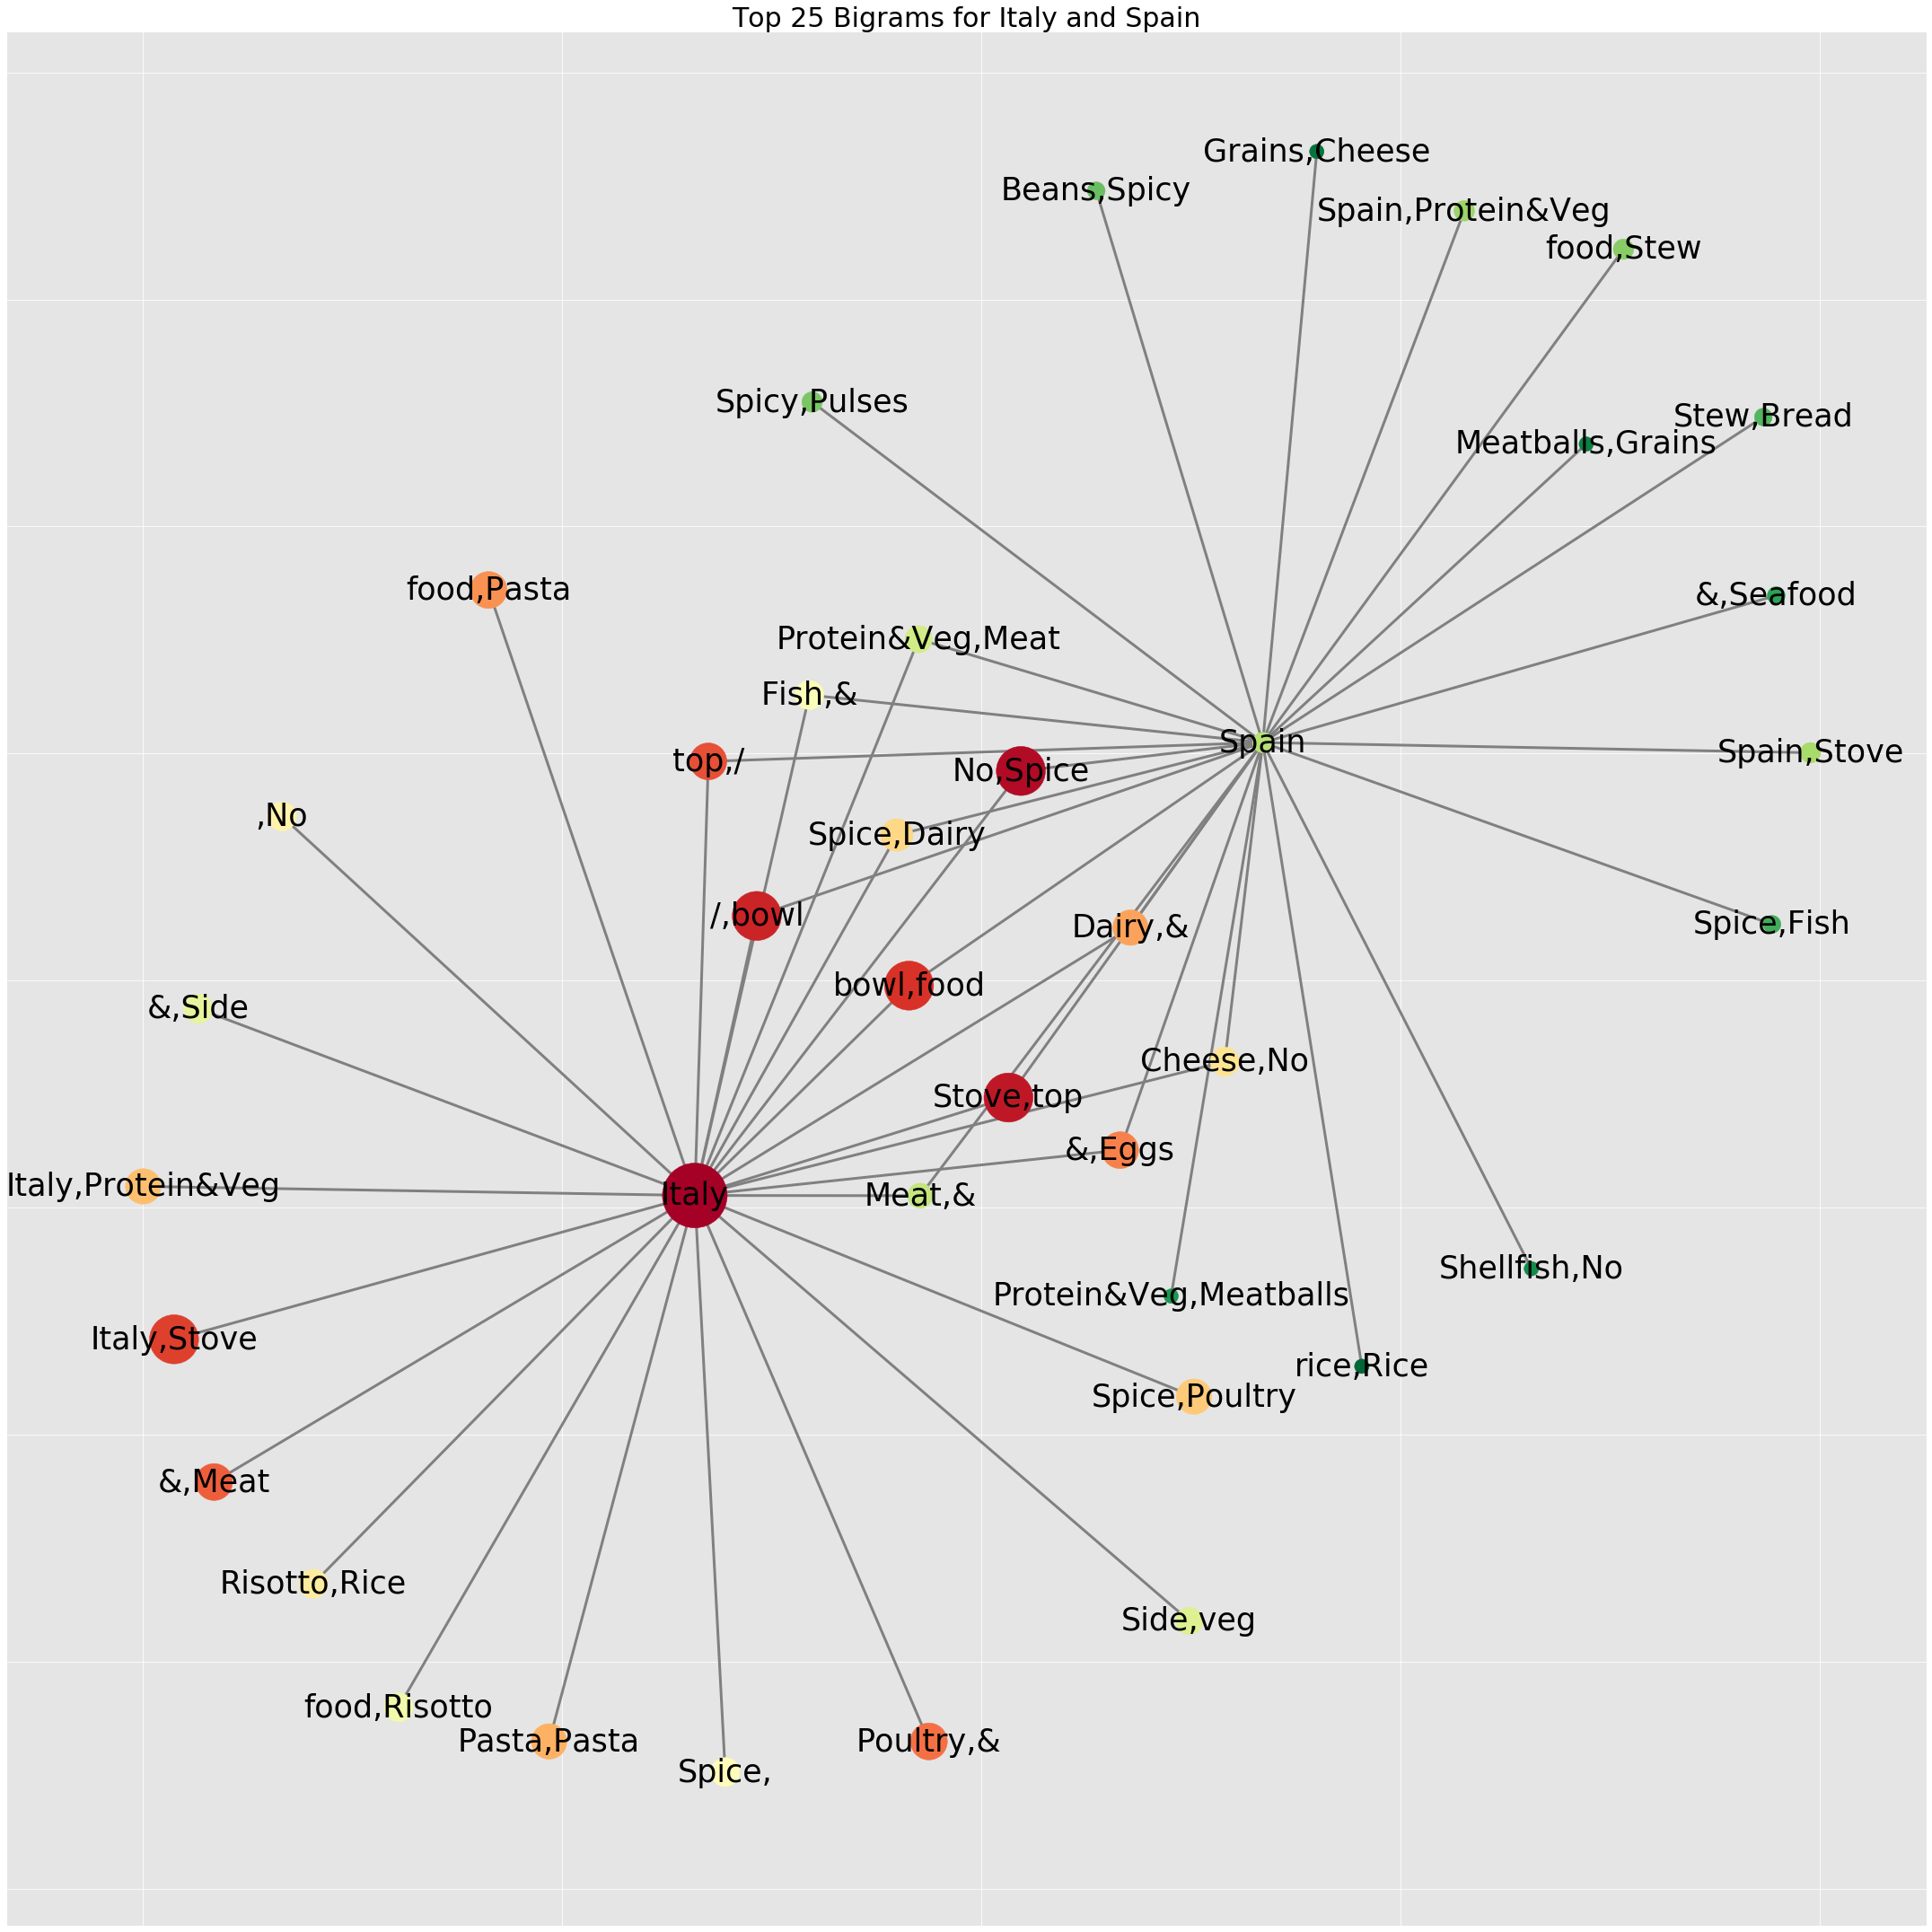

In [19]:
networkx_column_values('Italy', 'Spain', 'country')